In [ ]:
from bliss.grid import shift_sources

import matplotlib.pyplot as plt
from astropy.table import Table
from bliss.datasets.table_utils import column_to_tensor
from bliss.datasets.lsst import get_default_lsst_psf
from bliss.datasets.generate_blends import generate_dataset
from bliss.datasets.render_utils import sample_galaxy_params, render_one_galaxy
from einops import rearrange

from functools import partial
import torch
from jax import vmap
from torch_jax_interop import torch_to_jax

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()
new_table = catsim_table[catsim_table['i_ab'] < 23]

n_samples = 6

In [ ]:
gparams, _ = sample_galaxy_params(new_table, 6, 6)
gparams.shape

torch.Size([6, 11])

In [ ]:
# makes tiles of 53x53
ptiles = [render_one_galaxy(gparam, psf, 53) for gparam in gparams]
ptiles = rearrange(torch.cat(ptiles, axis=0), 'n h w -> n 1 h w')
ptiles.shape

torch.Size([6, 1, 53, 53])

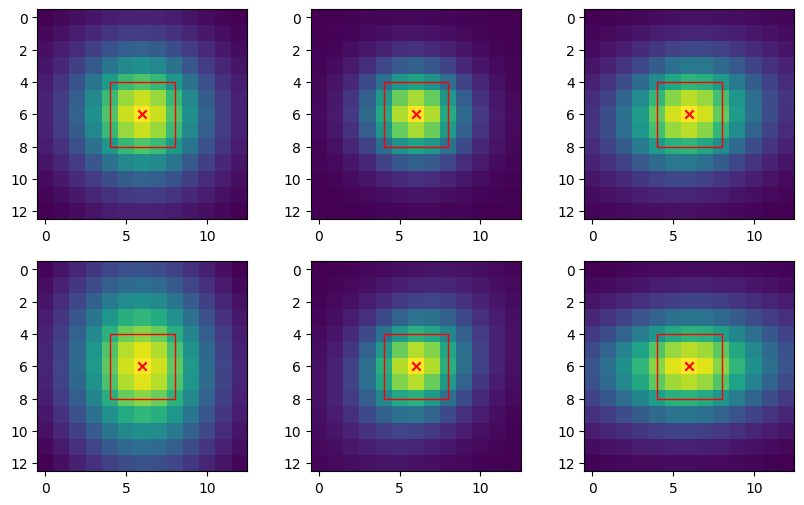

In [ ]:
import matplotlib.patches as patches


# plot them , all should be centered in central pixel
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
trim = 20
for ii, ax in enumerate(axes.flat):
    ax.imshow(ptiles[ii, 0, trim:-trim, trim:-trim].numpy(), interpolation='none')

    ax.scatter(53/2-0.5-trim, 53/2-0.5-trim, color='r', marker='x')

    # square of 4 pixels centered (not possible!, odd image), so not aligned with pixels
    rect = patches.Rectangle((53/2-0.5-2-trim, 53/2-0.5-2-trim), 4, 4, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [ ]:
ptiles.shape

torch.Size([6, 1, 53, 53])

In [ ]:
# now let's try shifting these images by some locs using the `shift_sources_in_ptiles`
# we will also make the `shift_sources_in_ptiles` function 
from torch_jax_interop import jax_to_torch

locs = torch.zeros((6, 2)) + 0.0
out_ptiles = shift_sources(ptiles, locs, tile_slen=4, slen=52, center=False)
out_ptiles.shape

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax_galsim/image.py:469: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.zeros(shape=shape, dtype=dtype)
/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:188: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


torch.Size([6, 1, 52, 52])

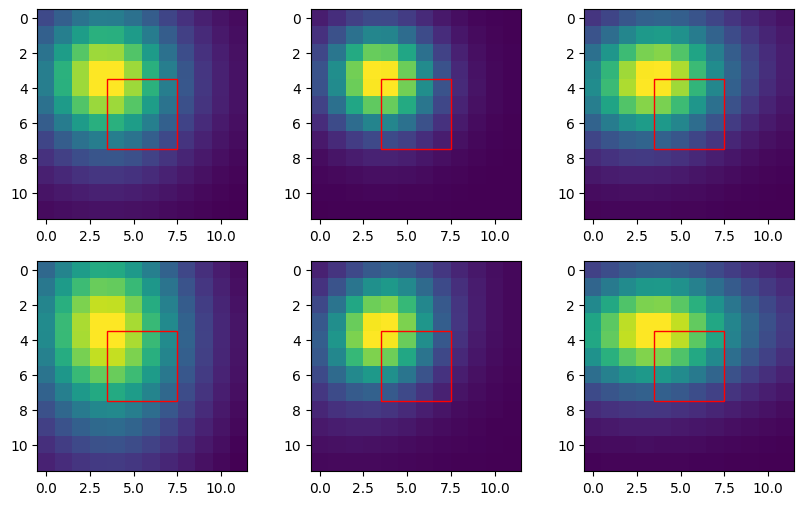

In [ ]:
# plot them , all should be centered in central pixel
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
trim = 20
for ii, ax in enumerate(axes.flat):
    ax.imshow(out_ptiles[ii, 0, trim:-trim, trim:-trim].numpy(), interpolation='none')
    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2-trim, 25.5-2-trim), 4, 4, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [ ]:
# now shift them back and replot
locs = torch.zeros((6, 2)) + 0
out_ptiles2 = shift_sources(out_ptiles, locs, tile_slen=4, slen=52, center=True)
out_ptiles2.shape

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax_galsim/image.py:469: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.zeros(shape=shape, dtype=dtype)
/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:188: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


torch.Size([6, 1, 52, 52])

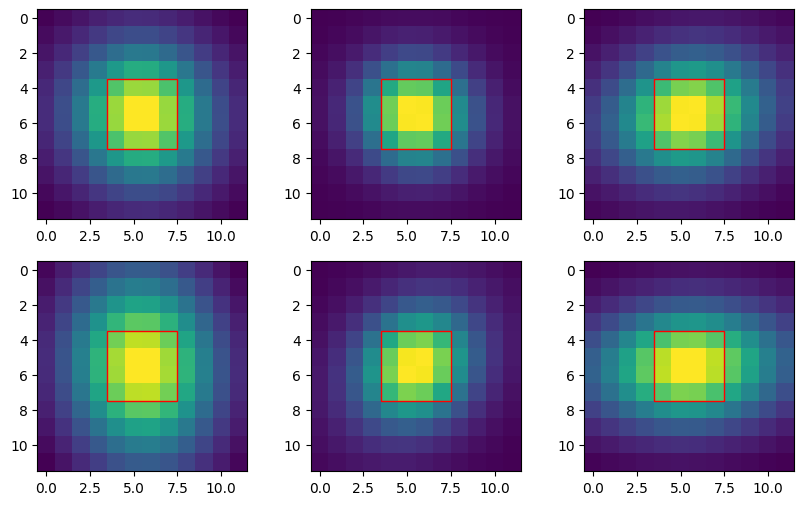

In [ ]:
# plot them , all should be centered in central pixel
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
trim = 20
for ii, ax in enumerate(axes.flat):
    ax.imshow(out_ptiles2[ii, 0, trim:-trim, trim:-trim].numpy(), interpolation='none')

    # ax.scatter(52/2-0.5-trim, 52/2-0.5-trim, color='r', marker='x')

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2-trim, 25.5-2-trim), 4, 4, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)